In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from typing import List, Literal

import mediapy as media
import numpy as np
import torch
import tqdm
from config_tools.common import get_typed_root_config
from einops import rearrange
from hydra import compose, initialize

# import ipython display
from IPython import display
from jacobian.dataset.pusher_dataset import Trajectory
from jacobian.utils.io import load_gzip_file, save_gzip_file
from mujoco_sim.env.base_env import RobotEnvCfg, RobotEnv
from raft_wrapper import InputPadder, RaftWrapper
from raft_wrapper.raft import resize_batched_flow, resize_batched_frames
from torchvision.utils import flow_to_image

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)


WARNING! gymnasium is not installed. We will try to use openai gym instead.


# Tutorial 2: Training Jacobian Fields in 2D Finger Environment.

Author: [Sizhe Lester Li](https://sizhe-li.github.io/), PhD Student, MIT CSAIL

## A. Learning Outcomes
In this tutorial, I will demonstrate why Jacobian Fields can capture the local structures of robotic systems' dynamics.

By the end of the tutorial, you will understand
1. **Spatial locality** of mechanical systems can be captured by Jacobian Fields.
1. **Spatial compositionality** of mechanical systems can be captured by Jacobian Fields.
3. **Linearity of mechanical systems** can be captured by Jacobian Fields.

We welcome further theoretical works and investigations in these directions and think that they are promising future research directions!


## B. Dexterous Finger Environment Description

The environment contains a 2 degrees-of-freedom robot finger. The robot finger is commanded by a 2D joint velocity command $\delta u \triangleq (u_1, u_2)$, where $u_1, u_2 \in \mathbb{R}$ control the rotations of each motor respectively. 

## BibTeX
Please consider citing our work if you find that our work is helpful for your research endeavors :D
```
@Article{Li2025,
  author={Li, Sizhe Lester
  and Zhang, Annan
  and Chen, Boyuan
  and Matusik, Hanna
  and Liu, Chao
  and Rus, Daniela
  and Sitzmann, Vincent},
  title={Controlling diverse robots by inferring Jacobian fields with deep networks},
  journal={Nature},
  year={2025},
  month={Jun},
  day={25},
  issn={1476-4687},
  doi={10.1038/s41586-025-09170-0},
  url={https://doi.org/10.1038/s41586-025-09170-0}
}
```


## Important: download Pre-trained checkpoints

In order to run the four tutorials, you need to download pretrained checkpoints [here](https://drive.google.com/drive/folders/1fq0nngkeRWhCJ_CAyzQopYda20Zu-Zu8?usp=drive_link).

Replace the following with your downloaded directories

- `notebooks/inference_demo_data/real_world_pretrained_ckpts` 
- `notebooks/tutorial/tutorial_pretrained_ckpts` 

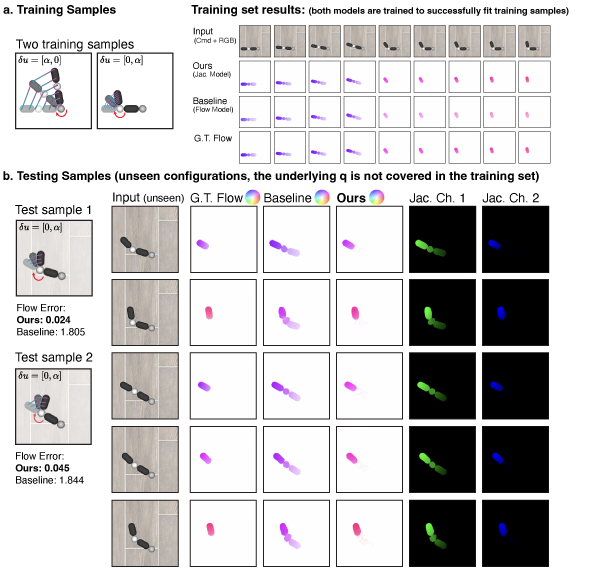

In [3]:
display.Image("FingerExample.png")

# 1. Loading Mujoco environment

In [4]:
from mujoco_sim.env.base_env import map_to_root

print(map_to_root)


/home/scene-rep-robot/scratch/neural-jacobian-field-public/mujoco-phys-sim


In [5]:
overrides = []

map_to_sim_root = Path("../../mujoco-phys-sim")
config_path = Path("phys_sim/configurations/left_finger.yaml")

with initialize(
    version_base=None, config_path=str(map_to_sim_root / config_path.parent)
):
    hydra_cfg = compose(
        config_name=str(config_path.name),
        overrides=overrides,
    )


env_cfg: RobotEnvCfg = get_typed_root_config(hydra_cfg, RobotEnvCfg)
env = RobotEnv(env_cfg, mj_model=None)
init_state = env.get_state()

Loading XML file /home/scene-rep-robot/scratch/neural-jacobian-field-public/mujoco-phys-sim/assets/mujoco/planar_hand_reorientation/scene_left_finger_only.xml


""

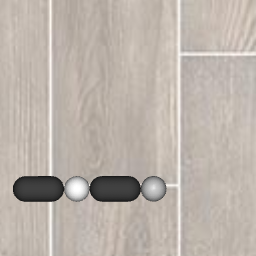

In [6]:
image = env.render("birdview")

media.show_image(image)

# 2. Rolling out dynamics to create a trajectory

To train our jacobian field, we need the following data pairs
- current observation: visual frame
- agent's action: the variation of robot's command, du
- perceptions of agent's action: visual optical flow

In the case of our pusher system, action is parameterized as the finite difference of agent's action between two timesteps. We will explain action parameterization in detail later. Stay tuned for now!


In [7]:
import tqdm
import torch
from raft_wrapper import (
    InputPadder,
    RaftWrapper,
    resize_batched_flow,
    resize_batched_frames,
)

device = torch.device("cuda:0")

raft = RaftWrapper()
raft = raft.eval()
raft.requires_grad_(False)
raft = raft.to(device)


def infer_raft_flow_over_torch_video(input_video_sequence, batch_size: int = 12):
    num_frames = len(input_video_sequence)

    input_frame_curr = input_video_sequence[:-1]
    input_frame_next = input_video_sequence[1:]

    raft_flow = []
    with torch.no_grad():
        for i in tqdm.trange(0, num_frames, batch_size, desc="Infer RAFT flow"):
            start_frame_index = i
            end_frame_index = min(i + batch_size, num_frames)

            input_frame_curr_raft, orig_size = resize_batched_frames(
                input_frame_curr[start_frame_index:end_frame_index]
            )
            input_frame_next_raft, _ = resize_batched_frames(
                input_frame_next[start_frame_index:end_frame_index]
            )

            mini_batch_trgt_flow = raft._forward_flow(
                input_frame_curr_raft, input_frame_next_raft
            )
            mini_batch_trgt_flow = resize_batched_flow(mini_batch_trgt_flow, *orig_size)

            raft_flow.append(mini_batch_trgt_flow)

        raft_flow = torch.cat(raft_flow, dim=0)

    return raft_flow  # (num_frames - 1, 2, H, W)

In [8]:
import numpy as np
from jacobian.utils.io import numpy_to_torch_image


qpos_limits = np.array(
    [
        [0, -1.4],  # min, max for the first joint
        [0, -1.4],  # min, max for the second joint
    ],
    dtype=np.float32,
)


#### create a sequence of qpos where only the first joint is moving
qpos0_seq = np.linspace(qpos_limits[0, 0], qpos_limits[0, 1], 30)
qpos1_seq = np.zeros_like(qpos0_seq)
qpos_seq_only_0 = np.stack([qpos0_seq, qpos1_seq], axis=1)


#### create a sequence of qpos where only the second joint is moving
qpos1_seq = np.linspace(qpos_limits[1, 0], qpos_limits[1, 1], 30)
qpos0_seq = np.zeros_like(qpos1_seq)
qpos_seq_only_1 = np.stack([qpos0_seq, qpos1_seq], axis=1)


def execute_trajectory(input_qpos_seq) -> Trajectory:

    traj_video = []
    for qpos_t in input_qpos_seq:
        env.sim.forward()
        env.sim.data.qpos[:2] = qpos_t
        env.sim.step()
        traj_video.append(env.render("birdview"))

    traj_video = np.stack(traj_video, axis=0)
    traj_qpos = input_qpos_seq.copy()

    traj_video_th = [numpy_to_torch_image(x) for x in traj_video]
    traj_video_th = torch.stack(traj_video_th, dim=0).to(device)
    traj_flow = infer_raft_flow_over_torch_video(traj_video_th).cpu().numpy()

    traj_dict = {
        "seq_rgb_obs": traj_video[:-1],
        "seq_qpos": traj_qpos[:-1],
        "seq_flow_obs": traj_flow,
    }

    print(
        f"""Shape of tensors
            seq_rgb_obs: {traj_dict["seq_rgb_obs"].shape}
            seq_qpos: {traj_dict["seq_qpos"].shape}
            seq_flow_obs: {traj_dict["seq_flow_obs"].shape}
          """
    )

    return Trajectory(**traj_dict)

In [9]:
from jacobian.utils.io import create_folder, save_gzip_file

root_dir = Path(
    "/home/sizheli/project/scene-jacobian-discovery/data/left_finger/two_training_samples/"
)

### create data
map_to_root = Path("../..")
save_dir = map_to_root / "data/left_finger"
# save trajectory
train_dir = save_dir / "train"
val_dir = save_dir / "val"

# make these directories if not exist
create_folder(train_dir, remove_exists=False)
create_folder(val_dir, remove_exists=False)

In [10]:
qpos1_seq = np.linspace(qpos_limits[1, 0], qpos_limits[1, 1], 30)
# randomly select a value from the qpos1 limits and repeat it to the same length as qpos0_seq
rand_qpos0 = np.random.uniform(qpos_limits[0, 0], qpos_limits[0, 1])
qpos0_seq = np.ones_like(qpos0_seq) * rand_qpos0

qpos_seq_rand_qpos0_walk_over_qpos1 = np.stack([qpos0_seq, qpos1_seq], axis=1)
trajectory_rand_qpos0_walk_over_qpos1 = execute_trajectory(
    qpos_seq_rand_qpos0_walk_over_qpos1
)


qpos0_seq = np.linspace(qpos_limits[0, 0], qpos_limits[0, 1], 30)
# randomly select a value from the qpos1 limits and repeat it to the same length as qpos0_seq
rand_qpos1 = np.random.uniform(qpos_limits[1, 0], qpos_limits[1, 1])
qpos1_seq = np.ones_like(qpos0_seq) * rand_qpos1

qpos_seq_rand_qpos1_walk_over_qpos0 = np.stack([qpos0_seq, qpos1_seq], axis=1)
trajectory_rand_qpos1_walk_over_qpos0 = execute_trajectory(
    qpos_seq_rand_qpos1_walk_over_qpos0
)

media.show_videos(
    [
        trajectory_rand_qpos0_walk_over_qpos1["seq_rgb_obs"],
        trajectory_rand_qpos1_walk_over_qpos0["seq_rgb_obs"],
    ],
    fps=10,
    titles=["only joint 0 moving", "only joint 1 moving"],
)

save_gzip_file(
    trajectory_rand_qpos0_walk_over_qpos1,
    train_dir / "trajectory_rand_qpos0_walk_over_qpos1.pkl",
)
save_gzip_file(
    trajectory_rand_qpos1_walk_over_qpos0,
    train_dir / "trajectory_rand_qpos1_walk_over_qpos0.pkl",
)
save_gzip_file(
    trajectory_rand_qpos0_walk_over_qpos1,
    val_dir / "trajectory_rand_qpos0_walk_over_qpos1.pkl",
)
save_gzip_file(
    trajectory_rand_qpos1_walk_over_qpos0,
    val_dir / "trajectory_rand_qpos1_walk_over_qpos0.pkl",
)

Infer RAFT flow:   0%|          | 0/3 [00:00<?, ?it/s]

Infer RAFT flow: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


Shape of tensors
            seq_rgb_obs: (29, 256, 256, 3)
            seq_qpos: (29, 2)
            seq_flow_obs: (29, 2, 256, 256)
          


Infer RAFT flow: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

Shape of tensors
            seq_rgb_obs: (29, 256, 256, 3)
            seq_qpos: (29, 2)
            seq_flow_obs: (29, 2, 256, 256)
          


In [11]:
trajectory_only_0 = execute_trajectory(qpos_seq_only_0)
trajectory_only_1 = execute_trajectory(qpos_seq_only_1)


media.show_videos(
    [trajectory_only_0["seq_rgb_obs"], trajectory_only_1["seq_rgb_obs"]],
    fps=10,
    titles=["only joint 0 moving", "only joint 1 moving"],
)

### save trajectories
save_gzip_file(trajectory_only_0, train_dir / "trajectory_only_0.pkl")
save_gzip_file(trajectory_only_1, train_dir / "trajectory_only_1.pkl")

save_gzip_file(trajectory_only_0, val_dir / "trajectory_only_0.pkl")
save_gzip_file(trajectory_only_1, val_dir / "trajectory_only_1.pkl")

Infer RAFT flow:   0%|          | 0/3 [00:00<?, ?it/s]

Infer RAFT flow: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Shape of tensors
            seq_rgb_obs: (29, 256, 256, 3)
            seq_qpos: (29, 2)
            seq_flow_obs: (29, 2, 256, 256)
          


Infer RAFT flow: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

Shape of tensors
            seq_rgb_obs: (29, 256, 256, 3)
            seq_qpos: (29, 2)
            seq_flow_obs: (29, 2, 256, 256)
          


# 3. Training our jacobian field!

### A. Training Commands
Running this script and train till convergence will give us the Jacobian fields!

```bash
conda activate neural-jacobian-field-public
python3 -m jacobian.train dataset=left_finger wrapper=left_finger wandb.mode=online wandb.name=left_finger 
```


## Loading trained model
After training, let's load up our trained model!

In [ ]:
import torch
import numpy as np

from jacobian.train import PipelineCfg
from jacobian.models.model_wrapper_base import get_wrapper

device = torch.device("cuda:0")


config_path = Path("project/jacobian/configurations/config.yaml")

checkpoint_path = "./tutorial_pretrained_ckpts/h918ryr7/model.ckpt"
model_name_kwrd = "transformer_jacobian"

overrides = [
    "dataset=left_finger",
    "wrapper=left_finger",
]


with initialize(version_base=None, config_path=str("../../" / config_path.parent)):
    hydra_cfg = compose(config_name=str(config_path.name), overrides=overrides)

cfg: PipelineCfg = get_typed_root_config(hydra_cfg, PipelineCfg)

wrapper = get_wrapper(cfg.wrapper)
model = wrapper.model

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
Using cache found in /home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main
/home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/scene-rep-robot/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is 

In [13]:
checkpoint = torch.load(checkpoint_path)

msg = wrapper.load_state_dict(checkpoint["state_dict"], strict=False)
print(msg)

wrapper.eval()
print("finished loading model")
wrapper.to(device)

<All keys matched successfully>
finished loading model


PlanarHandModelWrapper(
  (model): TransformerJacobianField(
    (dino): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=1536, o

In [14]:
import torch
from jacobian.dataset.pusher_dataset import Trajectory, numpy_to_torch_image
from jacobian.utils.io import load_gzip_file

min_qpos = torch.tensor([-1.4, -1.4], dtype=torch.float32)[None]
max_qpos = torch.tensor([0.0, 0.0], dtype=torch.float32)[None]
action_scale: float = 4.0


def get_val_item(trajectory_path):

    trajectory: Trajectory = load_gzip_file(trajectory_path)

    input_video_sequence = trajectory["seq_rgb_obs"]
    joint_pos_sequence = torch.from_numpy(trajectory["seq_qpos"])
    joint_pos_sequence = joint_pos_sequence[..., :2]  # num_steps x command_dim

    traj_flow_sequence = torch.from_numpy(trajectory["seq_flow_obs"])

    # normalize the joint_pos sequence
    joint_pos_sequence = (joint_pos_sequence - min_qpos) / (max_qpos - min_qpos)

    input_video_sequence = torch.stack(
        [numpy_to_torch_image(img) for img in input_video_sequence], dim=0
    )

    # grab the current joint pos
    input_command_sequence = action_scale * (
        joint_pos_sequence[1:] - joint_pos_sequence[:-1]
    )

    new_H, new_W = cfg.dataset.new_H, cfg.dataset.new_W
    if new_H is not None and new_W is not None:
        input_video_sequence = torch.nn.functional.interpolate(
            input_video_sequence, size=(new_H, new_W)
        )

        traj_flow_sequence = resize_batched_flow(traj_flow_sequence, new_H, new_W)

    return {
        "input_video_sequence": input_video_sequence.float(),
        "input_command_sequence": input_command_sequence.float(),
        "trgt_flow_sequence": traj_flow_sequence.float(),
    }

In [15]:
import cv2
from einops import rearrange, einsum


def draw_flow_arrows(
    canvas: np.ndarray,
    flow_img: np.ndarray,
    color: tuple = (255, 255, 255),
    threshold: float = 1.0,
    sparsity: int = 20,
):
    assert (
        flow_img.shape[:2] == canvas.shape[:2]
    ), f"canvas shape is {canvas.shape}, flow shape is {flow_img.shape}"
    H, W = flow_img.shape[:2]

    # draw flow arrows
    for y in range(0, H, sparsity):
        for x in range(0, W, sparsity):
            dx, dy = flow_img[y, x].astype(int)
            # if the flow is too small, ignore
            if abs(dx) < threshold and abs(dy) < threshold:
                continue

            cv2.arrowedLine(
                canvas,
                (x, y),
                (x + 2 * dx, y + 2 * dy),
                color=color,
                thickness=1,
                tipLength=0.3,
            )

    return canvas


def draw_jacobian_channels(vis_outputs):
    video_grid = []
    num_command_channels = 2

    jacobian_raw = vis_outputs["total_pred_jacobian_raw"][0] * -1
    diag_commands = torch.eye(num_command_channels).to(device)
    channel_wise_flow_field = einsum(
        jacobian_raw,
        diag_commands,
        "timestep command_dim spatial_dim height width, num_rows command_dim -> num_rows timestep spatial_dim height width",
    )

    channel_wise_flow_field = rearrange(
        channel_wise_flow_field,
        "num_rows timestep spatial_dim height width -> num_rows timestep height width spatial_dim",
    )

    for i in range(num_command_channels):
        video = vis_outputs["total_pred_jacobian_rgb"][0, :, i, :, :, :]
        video = rearrange(video, "t c h w -> t h w c").cpu().numpy()

        video_with_flow_annotated = []
        for frame_idx in range(video.shape[0]):
            frame = video[frame_idx].copy()
            this_frame_flow_field = channel_wise_flow_field[i, frame_idx].cpu().numpy()
            this_frame_flow_field *= 0.5
            # flow_img = flow_to_image(flow_img)

            frame = draw_flow_arrows(
                frame,
                this_frame_flow_field,
                threshold=0.5,
                sparsity=15,
            )
            video_with_flow_annotated.append(frame)
            # break

        video_grid.append(video_with_flow_annotated)
        # break

    return video_grid

## Loading validation data

In [18]:
# visualize val samples

### create data
map_to_root = Path("../..")
save_dir = map_to_root / "data/left_finger"
val_datafiles = list(Path(save_dir / "val").rglob("*.pkl"))

videos = []
video_titles = []
for i, datafile in enumerate(val_datafiles):
    data = load_gzip_file(datafile)
    images = data["seq_rgb_obs"]  # T H W C
    H, W = images.shape[1:3]
    videos.append(images)
    video_titles.append(datafile.name)


media.show_videos(
    videos,
    fps=10,
    height=H,
    width=W,
    titles=video_titles,
)

## Testing our model!

In [ ]:
# print()

from einops import rearrange
from jacobian.models.model_wrapper_planar_hand import (
    compute_sensitivity,
    visualize_sensitivity,
)

for i, datafile in enumerate(val_datafiles):
    data_dict = get_val_item(datafile)

    # move data to device
    for k in data_dict.keys():
        data_dict[k] = data_dict[k].to(device)

    vis_outputs = wrapper.visualize_model(
        input_video_sequence=data_dict["input_video_sequence"][:-1][None],
        input_command_sequence=data_dict["input_command_sequence"][None],
        trgt_flow_sequence=data_dict["trgt_flow_sequence"][:-1][None],
    )

    jacobian_videos = draw_jacobian_channels(vis_outputs)
    input_video = (
        rearrange(vis_outputs["input_video_sequences"][0], "t c h w -> t h w c")
        .cpu()
        .numpy()
    )
    trgt_flow_video = (
        rearrange(
            flow_to_image(vis_outputs["trgt_flow_sequences"][0]),
            "t c h w -> t h w c",
        )
        .cpu()
        .numpy()
    )
    pred_flow_video = (
        rearrange(vis_outputs["total_pred_flow_rgb"][0], "t c h w -> t h w c")
        .cpu()
        .numpy()
    )

    media.show_videos(
        [
            input_video,
            trgt_flow_video,
            pred_flow_video,
            jacobian_videos[0],
            jacobian_videos[1],
        ],
        titles=[
            "input_video",
            "ground_truth_optical_flow",
            "pred_optical_flow",
            "jacobian_channel_0",
            "jacobian_channel_1",
        ],
        fps=10,
    )

Processing validation: 100%|██████████| 6/6 [00:00<00:00, 61.94it/s]


Processing validation: 100%|██████████| 6/6 [00:00<00:00, 62.99it/s]


Processing validation: 100%|██████████| 6/6 [00:00<00:00, 63.36it/s]


Processing validation: 100%|██████████| 6/6 [00:00<00:00, 63.34it/s]


## Conclusion

Thank you for your attention! That concludes our second tutorial. Please post issues under our github repo or email sizheli@mit.edu for any suggestions / typos / questions. Thank you!
